In [1]:
!pip install pgmpy

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import os
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\SIDDHESHWAR
[nltk_data]     DUBEY\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
extract_path = "DATA_KAGGLE"

In [5]:
true_file = [f for f in os.listdir(extract_path) if "true" in f.lower()][0]
fake_file = [f for f in os.listdir(extract_path) if "fake" in f.lower()][0]


In [6]:
df_true = pd.read_csv(os.path.join(extract_path, true_file))
df_fake = pd.read_csv(os.path.join(extract_path, fake_file))

df_true["label"] = 0
df_fake["label"] = 1

df = pd.concat([df_true, df_fake], axis=0).reset_index(drop=True)

In [7]:
# Step 2: Feature Engineering
# Categorizing bias based on subject
df['bias'] = df['subject'].map(lambda x: 1 if x.lower() in ['politics', 'government', 'worldnews'] else 0)

In [8]:
# Detecting suspicious words
df['news_type'] = df['text'].apply(lambda x: 1 if isinstance(x, str) and any(word in x.lower() 
                                             for word in ['scandal', 'secret', 'shocking', 'breaking', 'conspiracy']) 
                                    else 0)


In [9]:
# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0)
df['sentiment_category'] = df['sentiment'].apply(lambda x: 1 if x < -0.1 else (2 if x > 0.1 else 0))  # 1 = Negative, 2 = Positive, 0 = Neutral

In [10]:
# Step 3: Text Preprocessing for Naive Bayes
X = df['text']
y = df['label']
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [11]:
# Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
# Step 4: Train Naïve Bayes Classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [13]:
# Validate Model
val_predictions = nb.predict(X_val)
print("Validation Set Evaluation:")
print(classification_report(y_val, val_predictions))

Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      3262
           1       0.93      0.94      0.93      3473

    accuracy                           0.93      6735
   macro avg       0.93      0.93      0.93      6735
weighted avg       0.93      0.93      0.93      6735



In [14]:
# Bayesian Decision Theory Classification
probabilities = nb.predict_proba(X_test)


In [15]:

lambda_01 = 2  # Cost of False Negative
lambda_10 = 1  # Cost of False Positive

In [16]:
def bayesian_decision_rule(prob_fake, prob_real, lambda_01, lambda_10):
    risk_fake = prob_fake * lambda_01
    risk_real = prob_real * lambda_10
    return 1 if risk_fake > risk_real else 0  # 1 = Fake, 0 = Real

In [17]:
predictions = [bayesian_decision_rule(p[1], p[0], lambda_01, lambda_10) for p in probabilities]

In [18]:
print("Test Set Evaluation:")
print(classification_report(y_test, predictions))

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      3212
           1       0.89      0.96      0.92      3523

    accuracy                           0.92      6735
   macro avg       0.92      0.91      0.91      6735
weighted avg       0.92      0.92      0.92      6735



In [ ]:
# Step 5: Bayesian Network Construction
model = BayesianNetwork([('bias', 'news_type'), ('news_type', 'sentiment_category'), ('sentiment_category', 'label')])
df_bayes = df[['bias', 'news_type', 'sentiment_category', 'label']]

NameError: name 'DiscreteBayesianNetwork' is not defined

In [ ]:
# Fit Bayesian Network
model.fit(df_bayes, estimator=MaximumLikelihoodEstimator)

In [ ]:
# Perform inference
infer = VariableElimination(model)
query_result = infer.query(variables=['label'], evidence={'bias': 1, 'news_type': 1, 'sentiment_category': 1})
print("\nProbability of news being fake given high bias, suspicious content, and negative sentiment:")
print(query_result)



Probability of news being fake given high bias, suspicious content, and negative sentiment:
+----------+--------------+
| label    |   phi(label) |
+==========+==============+
| label(0) |       0.4391 |
+----------+--------------+
| label(1) |       0.5609 |
+----------+--------------+


In [ ]:
# Display classification report
from sklearn.metrics import classification_report

print("Test Set Evaluation:")
print(classification_report(y_test, predictions))

# Display Bayesian Inference results
query_result = infer.query(variables=['label'], evidence={'bias': 1, 'news_type': 1})
print("\nProbability of news being fake given high bias source and suspicious content:")
print(query_result)


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      3212
           1       0.89      0.96      0.92      3523

    accuracy                           0.92      6735
   macro avg       0.92      0.91      0.91      6735
weighted avg       0.92      0.92      0.92      6735


Probability of news being fake given high bias source and suspicious content:
+----------+--------------+
| label    |   phi(label) |
+==========+==============+
| label(0) |       0.4794 |
+----------+--------------+
| label(1) |       0.5206 |
+----------+--------------+


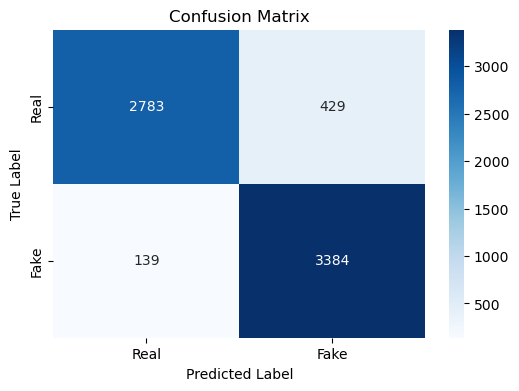

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


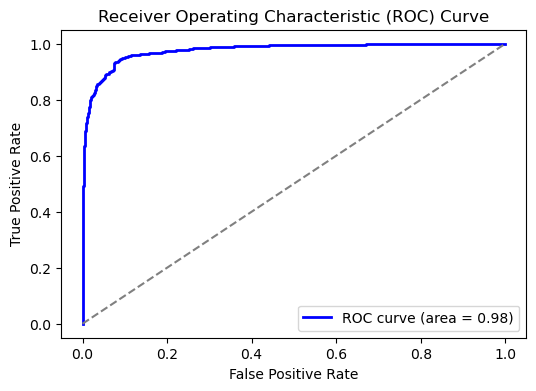

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
